In [39]:
import xgboost
from sklearn.model_selection import KFold, cross_validate,cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import normalize
from sklearn import svm
import matplotlib.pyplot as plt
from vis_utils import plot_confusion_matrix
from constants import LABEL_MAP, CLASSES_NAMES, TAG_KEYWORDS
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

LOADING DATA
======

Loading the data from the sections.csv into a pandas dataframe, saved by executing the firebase_data_export notebook (not available in the public repository).

All the instances (with their features) are stored din data as a numpy array.

The labels of the instances are stored in labels as a numpy array as well.

In [52]:
section_data = pd.read_csv('sections.csv')
features = list(section_data.columns.values)
features.remove('url')
small_features = ['x', 'y', 'left', 'right', 'top', 'bottom', 'width', 'height', 'pageAreaRatio', 'windowAreaRatio', 'childrenCount', 'wordCount']
for key in TAG_KEYWORDS:
    small_features.append('keyword-{0}'.format(key))
data = section_data.as_matrix(features)
data = normalize(data, axis=0)
small_data = section_data.as_matrix(small_features)
small_data = normalize(small_data, axis=0)
labels = section_data.as_matrix(['label']).flatten()
categorical_labels = to_categorical(labels, num_classes=None)
class_weights = compute_class_weight(class_weight='balanced', classes=range(0, 7), y=labels)
weights = {}
for i, w in enumerate(class_weights):
    weights[i] = w

FITTING ESTIMATORS
======

XGBOOST
-------
Fitting an XGBoost classifier an all the data, using 10-fold validation to compute a confusion matrix.

In [33]:
estimator = xgboost.XGBClassifier()
kfold = KFold(n_splits=10)
pred = cross_val_predict(estimator, data, labels, cv=kfold)
xg_conf_mat = confusion_matrix(labels, pred)
weak_pred = cross_val_predict(estimator, small_data, labels, cv=kfold)
xg_conf_mat_small = confusion_matrix(labels, pred)

/home/raulincze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/raulincze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/raulincze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/raulincze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/preprocess

NEURAL NETWORK
-----
Fitting a simple neural network classifier an all the data, using 10-fold validation to compute a confusion matrix.

In [ ]:
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(1024, input_dim=input_dim, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='relu'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    return model

def crossval_nn(data, labels):
    cv_preds = []
    cv_true = []
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    fold = 1
    for train, test in kfold.split(data, labels):
        print(fold)
        model = build_model(data.shape[1])
        #stop_callback = EarlyStopping(monitor='val_acc', patience=10, min_delta=0.00001)
        model.fit(data[train], categorical_labels[train], validation_data=(data[test], categorical_labels[test]), epochs=1500, batch_size=300, class_weight=weights, verbose=0)
        # evaluate the model
        preds = np.argmax(model.predict(data[test], verbose=0), axis=1)
        cv_preds = cv_preds + preds.tolist()
        cv_true = cv_true + labels[test].tolist()
        fold += 1
    return confusion_matrix(np.array(cv_true), np.array(cv_preds))

nn_conf_mat = crossval_nn(data, labels)
nn_conf_mat_small = crossval_nn(small_data, labels)

1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10


SUPPORT VECTOR MACHINE
-----
Fitting an SVM classifier with RBF kernel on all the data, using 10-fold validation to compute a confusion matrix.

In [53]:
def crossval_svm(data, labels):
    cv_preds = []
    cv_true = []
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    fold = 1
    for train, test in kfold.split(data, labels):
        print(fold)
        model = svm.SVC(decision_function_shape='ovo', class_weight=weights)
        #stop_callback = EarlyStopping(monitor='val_acc', patience=10, min_delta=0.00001)
        model.fit(data[train], labels[train])
        # evaluate the model
        preds = model.predict(data[test])
        cv_preds = cv_preds + preds.tolist()
        cv_true = cv_true + labels[test].tolist()
        fold += 1
    return confusion_matrix(np.array(cv_true), np.array(cv_preds))

svm_conf_mat = crossval_svm(data, labels)
svm_conf_mat_small = crossval_svm(small_data, labels)

1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10


RESULTS
======
Plotting the normalized confusion matrices resulted from the algorithms.

Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix


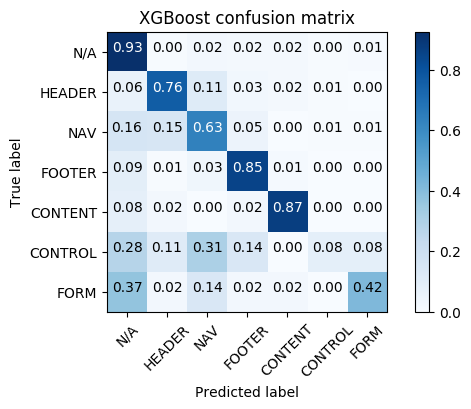

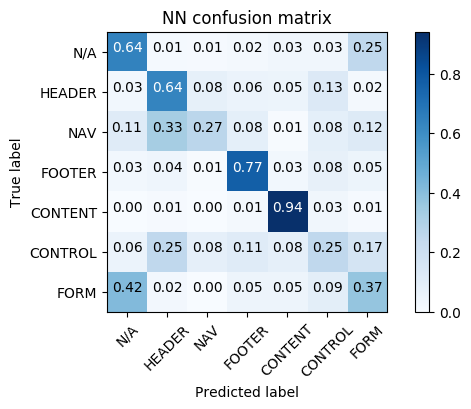

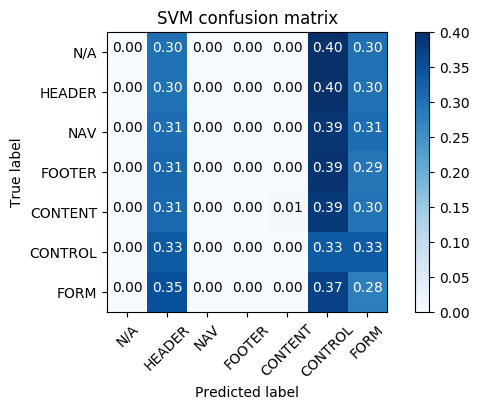

In [46]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(dpi=100)
plot_confusion_matrix(xg_conf_mat, classes=CLASSES_NAMES, normalize=True,
                      title='XGBoost confusion matrix')
plt.figure(dpi=100)
plot_confusion_matrix(nn_conf_mat, classes=CLASSES_NAMES, normalize=True,
                      title='NN confusion matrix')
plt.figure(dpi=100)
plot_confusion_matrix(svm_conf_mat, classes=CLASSES_NAMES, normalize=True,
                      title='SVM confusion matrix')

plt.show()